# DM-25824: Rotator/CCW synchronization test

This notebook contains queries to the EFD to analyse the data from the CCW-Rotator synchronization test.

The test consists of performing repetitive movements with the Rotator to see if the CCW can keep up.

The test can be driven by a notebook (`CCW-Rotator-IT.ipynb`) or using a Script (`maintel/integration_tests/ccw_rotator_stress.py` in `ts_standardscripts`).

In [1]:
import numpy as np
import pandas as pd

from astropy.time import Time
from datetime import timedelta, datetime

import lsst_efd_client

import matplotlib.pyplot as plt

plt.jet()

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters();

<Figure size 432x288 with 0 Axes>

In [2]:
client = lsst_efd_client.EfdClient('summit_efd')

## Querying data from EFD

The time set below is for when the test was originally performed at NCSA. This can be modified to query/analyse data taken on different runs.

In [3]:
start = Time('2020-11-12T14:10:00') #this is UTC
end = Time('2020-11-12T14:30:00')

Basically we want to compare the Rotator position, which is in the `Rotator.Application` topic, and the Camera Cable Wrap position, in the `MTMount.Camera_Cable_Wrap` topic.

One thing to remember is that, since the data is sent asynchronously by two different components, we need to resample them to the same time domain in order to be able to compare them. This is done using the `resample` utility method provided by `lsst_efd_client`, and it performs a simple interpolation to resample one data frame into another.

In [20]:
rot = await client.select_time_series('lsst.sal.Rotator.Application', 'Position, Demand, private_rcvStamp', 
                                     start.tai, end.tai)

ccw = await client.select_time_series('lsst.sal.MTMount.Camera_Cable_Wrap', 'CCW_Angle_1, CCW_Speed_1, private_rcvStamp', 
                                     start.tai, end.tai)


In [5]:
#rotcmd = await client.select_time_series('lsst.sal.Rotator.command_move', 'state', start.tai, end.tai)
rotcmd = await client.select_time_series('lsst.sal.Rotator.positionSet', 'angle', start.tai, end.tai)

rotcmd

""


In [19]:
pd.to_datetime(ccw['private_rcvStamp'],unit='s')

2020-11-12 14:10:37.007000+00:00   2020-11-12 14:10:13.823267460
2020-11-12 14:10:37.108000+00:00   2020-11-12 14:10:13.914457083
2020-11-12 14:10:37.207000+00:00   2020-11-12 14:10:14.004540205
2020-11-12 14:10:37.305000+00:00   2020-11-12 14:10:14.094060421
2020-11-12 14:10:37.404000+00:00   2020-11-12 14:10:14.184363842
                                                ...             
2020-11-12 14:30:36.506000+00:00   2020-11-12 14:28:24.267923831
2020-11-12 14:30:36.604000+00:00   2020-11-12 14:28:24.356696367
2020-11-12 14:30:36.705000+00:00   2020-11-12 14:28:24.448664427
2020-11-12 14:30:36.801000+00:00   2020-11-12 14:28:24.536482573
2020-11-12 14:30:36.903000+00:00   2020-11-12 14:28:24.629239559
Name: private_rcvStamp, Length: 12000, dtype: datetime64[ns]

In [ ]:
rot = rot.set_index('private_rcvStamp')
ccw = ccw.set_index('private_rcvStamp')

In [26]:
rot_ccw_resampled = lsst_efd_client.resample(rot, ccw)

## Rotator vs CCW Position.

The plot below show a direct comparison of the Rotator position with the CCW position.

In [28]:
rot

,Position,Demand
private_rcvStamp,,
1.605190e+09,-12.722947,-12.722972
1.605190e+09,-12.722947,-12.722972
1.605190e+09,-12.722949,-12.722972
1.605190e+09,-12.722947,-12.722972
1.605190e+09,-12.722947,-12.722972
...,...,...
1.605191e+09,40.398373,40.398351
1.605191e+09,40.398374,40.398351
1.605191e+09,40.398373,40.398351


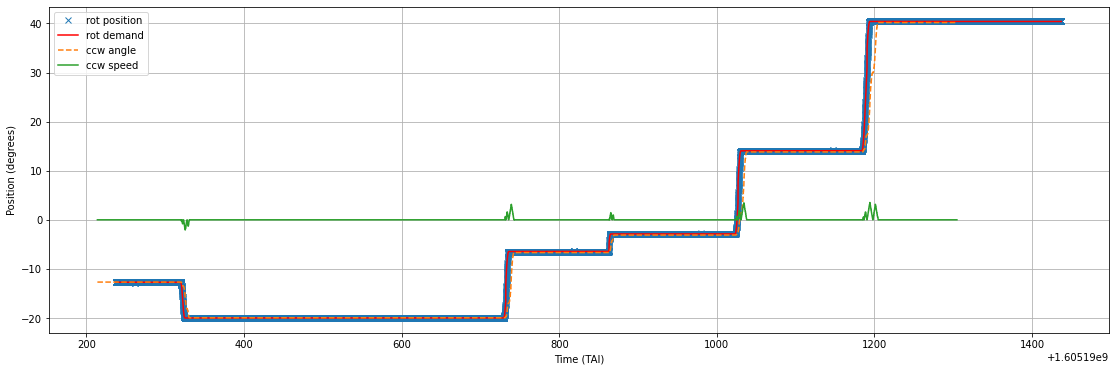

In [29]:
fig = plt.figure(1, (19, 6))

plt.plot(rot.Position,'x', label='rot position')
plt.plot(rot.Demand,'-r', label='rot demand')
plt.plot(ccw.CCW_Angle_1,'--', label='ccw angle')
plt.plot(ccw.CCW_Speed_1,'-', label='ccw speed')


plt.ylabel("Position (degrees)")
plt.xlabel("Time (TAI)")
plt.legend()

plt.grid()

The direct comparison above, althought good to understand what movement the Rotator was performing, does not allow a good comparison of how good the CCW was in following it. To highlight that, we use the resampled data to show the difference between Rotator and CCW position.

In [30]:
rot_ccw_resampled

,Position,Demand,CCW_Angle_1,CCW_Speed_1
private_rcvStamp,,,,
1.605190e+09,NaN,NaN,-12.6879,0.0
1.605190e+09,NaN,NaN,-12.6879,0.0
1.605190e+09,NaN,NaN,-12.6879,0.0
1.605190e+09,NaN,NaN,-12.6879,0.0
1.605190e+09,NaN,NaN,-12.6879,0.0
...,...,...,...,...
1.605191e+09,40.398373,40.398351,40.1820,0.0
1.605191e+09,40.398374,40.398351,40.1820,0.0
1.605191e+09,40.398373,40.398351,40.1820,0.0


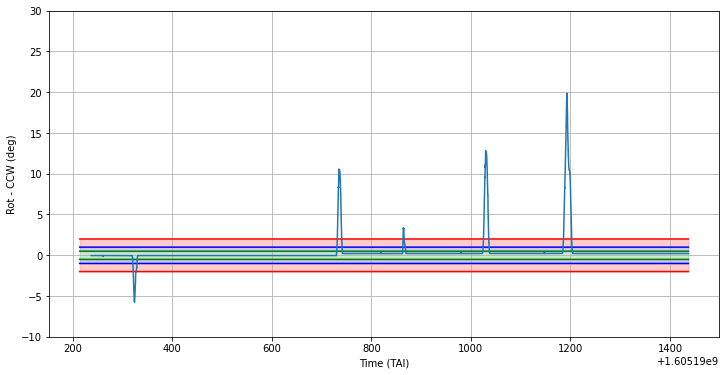

In [31]:
fig = plt.figure(1, (12, 6))

plt.fill_between(rot_ccw_resampled.index, 
                 np.zeros(len(rot_ccw_resampled.index))-0.5, 
                 np.zeros(len(rot_ccw_resampled.index))+0.5, 
                 alpha=0.2, color='g')
plt.fill_between(rot_ccw_resampled.index, 
                 np.zeros(len(rot_ccw_resampled.index))+0.5, 
                 np.zeros(len(rot_ccw_resampled.index))+1.0, 
                 alpha=0.2, color='b')
plt.fill_between(rot_ccw_resampled.index, 
                 np.zeros(len(rot_ccw_resampled.index))-0.5, 
                 np.zeros(len(rot_ccw_resampled.index))-1.0, 
                 alpha=0.2, color='b')
plt.fill_between(rot_ccw_resampled.index, 
                 np.zeros(len(rot_ccw_resampled.index))+1.0, 
                 np.zeros(len(rot_ccw_resampled.index))+2.0, 
                 alpha=0.2, color='r')
plt.fill_between(rot_ccw_resampled.index, 
                 np.zeros(len(rot_ccw_resampled.index))-1.0, 
                 np.zeros(len(rot_ccw_resampled.index))-2.0, 
                 alpha=0.2, color='r')

plt.plot(rot_ccw_resampled.index, np.zeros_like(rot_ccw_resampled.index)+2.0, "r-")
plt.plot(rot_ccw_resampled.index, np.zeros_like(rot_ccw_resampled.index)+1.0, "b-")
plt.plot(rot_ccw_resampled.index, np.zeros_like(rot_ccw_resampled.index)+0.5, "g-")

plt.plot(rot_ccw_resampled.index, np.zeros_like(rot_ccw_resampled.index)-0.5, "g-")
plt.plot(rot_ccw_resampled.index, np.zeros_like(rot_ccw_resampled.index)-1.0, "b-")
plt.plot(rot_ccw_resampled.index, np.zeros_like(rot_ccw_resampled.index)-2.0, "r-")


plt.plot(rot_ccw_resampled.Position-rot_ccw_resampled.CCW_Angle_1, '-')

plt.ylabel("Rot - CCW (deg)")
plt.xlabel("Time (TAI)")

#plt.ylim(-2.5, 2.5)
plt.ylim(-10, 30)
plt.grid()